<!-- # Published scoring

From https://github.com/OpenCLIM/ecocrop/blob/main/README.md?plain=1

## Temperature Suitability Scoring Method

The temperature score $S_T$ is calculated in two different methods dependent on whether or not the crop is usually grown as an annual or perennial crop.

### Annual Scoring Method

For annual crops, $S_T$ is calculated using the following method:

For each day, 1km grid cell and GTIME length, an intermediate score between 0 and 1 is assigned using the following equations:

$D= \frac{T-TMIN}{TOPMN-TMIN} \text{ when }TMIN\lt T \lt TOPMN$

$D=1 \text{ when } TOPMN\lt T\lt TOPMX$

$D= \frac{TMAX-T}{TMAX-TOPMX} \text{ when }TOPMX\lt T\lt TMAX$

$D=0\text{ for all other }T$

Where $T$ is the average temperature of the given day. A score of 1 represents a day that is maximally temperature suitable for the given crop, and 0 not suitable.

Then a sum of $D$ across the subsequent $GTIME$ days is calculated:

$$N_D=\sum_{days}^{GTIME}D$$

This sum, $N_D$, is the total number of suitable days within $GTIME$.

If $N_D$ is greater than or equal to $GMIN$, I.e. if at least the minimum number of suitable days is achieved within $GTIME$, then a suitability score $S_T$, dependent only on the given $GTIME$, is assigned to the given day:

$S_T=100\left[1-\frac{GTIME-GMIN}{GMAX-GMIN}\right]\text{ where } N_D≥GMIN\text{ else } S_T=0$

The result of this calculation is that the fewer days it takes to amass $GMIN$ suitable days, the higher the suitability score ($S_T$).


Heat stress and frost penalties are then applied to the suitability score to account for temperature extremes. Daily minimum temperatures within the $GTIME$ window are checked and if there is a daily-minimum temperature below $KTMP$ then $S_T$ is set to 0. A heat stress penalty is also applied by subtracting the number of days with a daily maximum temperature above $TMAX$ from $S_T$.


### Perennial Scoring Method

The temperature score for a given $GTIME$, day, grid square and crop is calculated as follows:
First, the average daily-average-temperature ($TAVG$) across $GTIME$ days into the future is calculated. Then the following equation is used to calculate the score, $S_T$:

$S_T=\frac{100}{0.5\left(TOPMX+TOPMN\right)-TMIN} \left(TAVG-TMIN\right)\text{ when } TMIN\lt TAVG\lt 0.5\left(TOPMX+TOPMN\right)$

$S_T=\frac{100}{TMAX-0.5\left(TOPMX+TOPMN\right)}\left(TMAX-TAVG\right)\text{ when } TMAX\gt TAVG\gt 0.5\left(TOPMX+TOPMN\right)$

$S_T=0\text{ for all other }TAVG$

The same heat and frost penalties as for the annual temperature suitability scoring method are then applied. -->

## load libraries

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import folium.plugins
import branca.colormap as cm
import rasterio

from shapely.geometry import Polygon, Point
import numpy as np
import xarray as xr
import random
import os
import time
import re
import math

import matplotlib.pyplot as plt
import altair as alt

In [2]:
# Set GeoPandas to use pyogrio
gpd.options.io_engine = "pyogrio"

In [3]:
gpd.show_versions()


SYSTEM INFO
-----------
python     : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:13:44) [Clang 16.0.6 ]
executable : /Users/jwhite/miniforge3/envs/siads699b/bin/python
machine    : macOS-14.5-arm64-arm-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.12.2
GEOS lib   : None
GDAL       : 3.9.1
GDAL data dir: /Users/jwhite/miniforge3/envs/siads699b/share/gdal/
PROJ       : 9.4.0
PROJ data dir: /Users/jwhite/miniforge3/envs/siads699b/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 1.0.1
numpy      : 2.0.0
pandas     : 2.2.2
pyproj     : 3.6.1
shapely    : 2.0.5
pyogrio    : 0.9.0
geoalchemy2: 0.15.2
geopy      : 2.4.1
matplotlib : 3.9.1
mapclassify: 2.6.1
fiona      : 1.9.6
psycopg    : 3.2.1
psycopg2   : 2.9.9 (dt dec pq3 ext lo64)
pyarrow    : 16.1.0


## folium map generator function

In [4]:
# List of available tiles with their attributions and layer names (including USGS maps)
tiles_list = [
    {"tiles": "https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}", "attr": 'U.S. Department of the Interior | U.S. Geological Survey', "name": "USGS Topo"},
    {"tiles": "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}", "attr": 'U.S. Department of the Interior | U.S. Geological Survey', "name": "USGS Imagery"},
    {"tiles": "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryTopo/MapServer/tile/{z}/{y}/{x}", "attr": 'U.S. Department of the Interior | U.S. Geological Survey', "name": "USGS Imagery Topo"},
    {"tiles": "OpenStreetMap", "attr": "© OpenStreetMap contributors", "name": "OpenStreetMap"},
    {"tiles": "https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png", "attr": '&copy; <a href="https://stadiamaps.com/" target="_blank">Stadia Maps</a> <a href="https://stamen.com/" target="_blank">&copy; Stamen Design</a> &copy; <a href="https://openmaptiles.org/" target="_blank">OpenMapTiles</a> &copy; <a href="https://www.openstreetmap.org/copyright" target="_blank">OpenStreetMap</a>', "name": "Stamen Toner Lite"},
]

def generate_folium_map_with_csb_centroids_and_colors(gdf, zoom=6, decimal_places=3):
    # Check CRS and convert to EPSG:4326 if needed
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs(epsg=4326)
    
    # Format latitude and longitude to the desired number of decimal places
    gdf['Longitude_formatted'] = gdf['Longitude'].map(lambda x: f'{x:>{decimal_places+4}.{decimal_places}f}')
    gdf['Latitude_formatted'] = gdf['Latitude'].map(lambda x: f'{x:>{decimal_places+4}.{decimal_places}f}')
    
    # Ensure necessary columns are included in the properties
    gdf = gdf[['geometry', 'CDL2023', 'Longitude', 'Latitude', 'Longitude_formatted', 'Latitude_formatted', 'color', 'Crop', 'Elevation']]
    
    def style_function(feature):
        return {
            'fillColor': feature['properties']['color'],
            'color': feature['properties']['color'],
            'weight': 1,
            'fillOpacity': 0.6
        }

    # Create a separate GeoDataFrame for the centroids
    centroids_gdf = gdf.copy()
    # centroids_gdf['geometry'] = centroids_gdf.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
    centroids_gdf['geometry'] = gpd.points_from_xy(centroids_gdf['Longitude'], centroids_gdf['Latitude'])
    
    # Convert geometries to GeoJSON
    geojson_data = gdf.to_json()
    centroids_geojson_data = centroids_gdf.to_json()
    
    # Calculate map center
    minx, miny, maxx, maxy = gdf.total_bounds
    center_longitude = (minx + maxx) / 2
    center_latitude = (miny + maxy) / 2
    
    # Initialize map
    m = folium.Map(location=[center_latitude, center_longitude], zoom_start=zoom, tiles=None)
    
    # Add each tile layer to the map
    for tile_info in tiles_list:
        tiles = tile_info["tiles"]
        attr = tile_info["attr"]
        layer_name = tile_info["name"]
        folium.TileLayer(tiles=tiles, attr=attr, name=layer_name).add_to(m)
    
    # Add GeoJSON layer with custom popups and styles for crop sequence boundaries
    folium.GeoJson(
        geojson_data,
        name='Crop Sequence Boundaries',
        style_function=style_function,
        popup=folium.GeoJsonPopup(fields=['CDL2023', 'Crop', 'Latitude_formatted', 'Longitude_formatted','Elevation'], aliases=['Crop ID:', 'Crop:', 'Latitude:', 'Longitude:', 'Elevation:'])
    ).add_to(m)
    
    # Add GeoJSON layer for centroids with custom CircleMarkers
    folium.GeoJson(
        centroids_geojson_data,
        name='CSB Centroids',
        # marker=folium.CircleMarker(radius=4, fill_color='grey', fill_opacity=1, color='grey', weight=0.2),
        marker=folium.CircleMarker(
            radius=4, 
            fill=True,
            fill_opacity=0.8,
            weight=0.2
        ),
        # marker=folium.CircleMarker(radius=4),
        style_function=lambda x: {'fillColor': x['properties']['color'], 'color': 'grey'},
        popup=folium.GeoJsonPopup(fields=['CDL2023', 'Crop', 'Latitude_formatted', 'Longitude_formatted', 'Elevation'], aliases=['Crop ID:', 'Crop:', 'Latitude:', 'Longitude:', 'Elevation:']),
    ).add_to(m)
    
    folium.plugins.Fullscreen(
        position="topleft",
        title="Fullscreen",
        title_cancel="Exit Fullscreen",
        force_separate_button=True,
    ).add_to(m)

    # Add layer control to the map
    folium.LayerControl().add_to(m)
    
    return m

## load crop sequence boundaries

In [5]:
# sample_data_file = '../data/agricultural/CSB/siads696/geo_balanced_sample.parquet'
sample_data_file = '../datasets/fields/csb/geo_balanced_sample.parquet'
geo_balanced_csb_samples = gpd.read_parquet(sample_data_file)
geo_balanced_csb_samples

CSBID CSBYEARS   CSBACRES  CDL2016  CDL2017  CDL2018  \
264164  081623007010852     1623  42.172442       61       21       28   
252748  081623006852860     1623   4.860087      152      142      152   
84983   491623015988100     1623   9.501533       36       36       36   
235900  081623006279628     1623   4.157208       61       61       24   
257008  081623006998069     1623   2.822090      176      176      205   
...                 ...      ...        ...      ...      ...      ...   
123484  351623003238938     1623   3.675615       36       36       36   
186470  081623001860231     1623   4.106779       36       36       36   
606785  041623013878701     1623   6.756011       61       29       61   
10124   491623005262153     1623  14.987005        1        1       37   
361912  081623009039516     1623   4.864824      176       37       37   

        CDL2019  CDL2020  CDL2021  CDL2022  ...      INSIDE_X      INSIDE_Y  \
264164       61       61      152      152  ... -8.485271e+05  1.598009e+06   
252748      152      152      152      152  ... -1.028570e+06  1.760491e+06   
84983        36       36       36       37  ... -1.532537e+06  1.703774e+06   
235900      152      176      176      152  ... -6.397665e+05  1.751563e+06   
257008      176      176      176      176  ... -6.313422e+05  1.648109e+06   
...         ...      ...      ...      ...  ...           ...           ...   
123484      152       36       36       36  ... -7.822644e+05  1.476764e+06   
186470       36       36       37      176  ... -1.080237e+06  1.682268e+06   
606785      176       61      176      176  ... -1.581930e+06  1.233847e+06   
10124        36       36       36       36  ... -1.446571e+06  1.793114e+06   
361912       37       37       37       37  ... -9.765179e+05  1.937270e+06   

            Shp_Len       Shp_Area  \
264164  3190.104461  170666.499331   
252748   846.919361   19668.154155   
84983   1280.502899   38451.493501   
235900   916.143112   16823.690749   
257008   593.762657   11420.640325   
...             ...            ...   
123484   523.612316   14874.747364   
186470   661.441173   16619.612976   
606785   997.719649   27340.715046   
10124   1962.223433   60650.501468   
361912   621.119568   19687.323173   

                                                 geometry   Longitude  \
264164  MULTIPOLYGON (((-848450.608 1598183.245, -8484... -105.646388   
252748  MULTIPOLYGON (((-1028621.215 1760502.389, -102... -107.903925   
84983   MULTIPOLYGON (((-1532428.499 1703868.12, -1532... -113.506127   
235900  MULTIPOLYGON (((-639769.777 1751684.884, -6397... -103.420132   
257008  MULTIPOLYGON (((-631348.266 1648020.38, -63137... -103.231477   
...                                                   ...         ...   
123484  MULTIPOLYGON (((-782216.336 1476841.652, -7822... -104.770515   
186470  MULTIPOLYGON (((-1080172.097 1682327.009, -108... -108.378030   
606785  MULTIPOLYGON (((-1581843.713 1233888.426, -158... -113.102678   
10124   MULTIPOLYGON (((-1446575.805 1793250.042, -144... -112.722394   
361912  MULTIPOLYGON (((-976444.368 1937340.125, -9764... -107.555017   

         Latitude  Elevation    color                   Crop  
264164  37.037619       2304  #bfbf7a   Fallow/Idle Cropland  
252748  38.295863       2390  #a5f58d  Other Hay/Non Alfalfa  
84983   37.102293        823  #ffa8e3                Alfalfa  
235900  38.568996       1386  #c7d79e              Shrubland  
257008  37.654274       1347  #e9ffbe          Grass/Pasture  
...           ...        ...      ...                    ...  
123484  36.017002       1941  #a5f58d  Other Hay/Non Alfalfa  
186470  37.545014       2395  #e9ffbe          Grass/Pasture  
606785  32.890867        225  #e9ffbe          Grass/Pasture  
10124   38.023977       1782  #ffa8e3                Alfalfa  
361912  39.918359       2452  #e9ffbe          Grass/Pasture  

[1200 rows x 26 columns]

In [6]:
list(geo_balanced_csb_samples.columns)

['CSBID',
 'CSBYEARS',
 'CSBACRES',
 'CDL2016',
 'CDL2017',
 'CDL2018',
 'CDL2019',
 'CDL2020',
 'CDL2021',
 'CDL2022',
 'CDL2023',
 'STATEFIPS',
 'STATEASD',
 'ASD',
 'CNTY',
 'CNTYFIPS',
 'INSIDE_X',
 'INSIDE_Y',
 'Shp_Len',
 'Shp_Area',
 'geometry',
 'Longitude',
 'Latitude',
 'Elevation',
 'color',
 'Crop']

In [7]:
field_data = geo_balanced_csb_samples.copy()

In [8]:
field_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1200 entries, 264164 to 361912
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CSBID      1200 non-null   object  
 1   CSBYEARS   1200 non-null   object  
 2   CSBACRES   1200 non-null   float64 
 3   CDL2016    1200 non-null   int64   
 4   CDL2017    1200 non-null   int64   
 5   CDL2018    1200 non-null   int64   
 6   CDL2019    1200 non-null   int64   
 7   CDL2020    1200 non-null   int64   
 8   CDL2021    1200 non-null   int64   
 9   CDL2022    1200 non-null   int64   
 10  CDL2023    1200 non-null   int64   
 11  STATEFIPS  1200 non-null   object  
 12  STATEASD   1200 non-null   object  
 13  ASD        1200 non-null   object  
 14  CNTY       1200 non-null   object  
 15  CNTYFIPS   1200 non-null   object  
 16  INSIDE_X   1200 non-null   float64 
 17  INSIDE_Y   1200 non-null   float64 
 18  Shp_Len    1200 non-null   float64 
 19  Shp_Area   1200 n

In [9]:
m = generate_folium_map_with_csb_centroids_and_colors(field_data)

In [10]:
m

<!-- 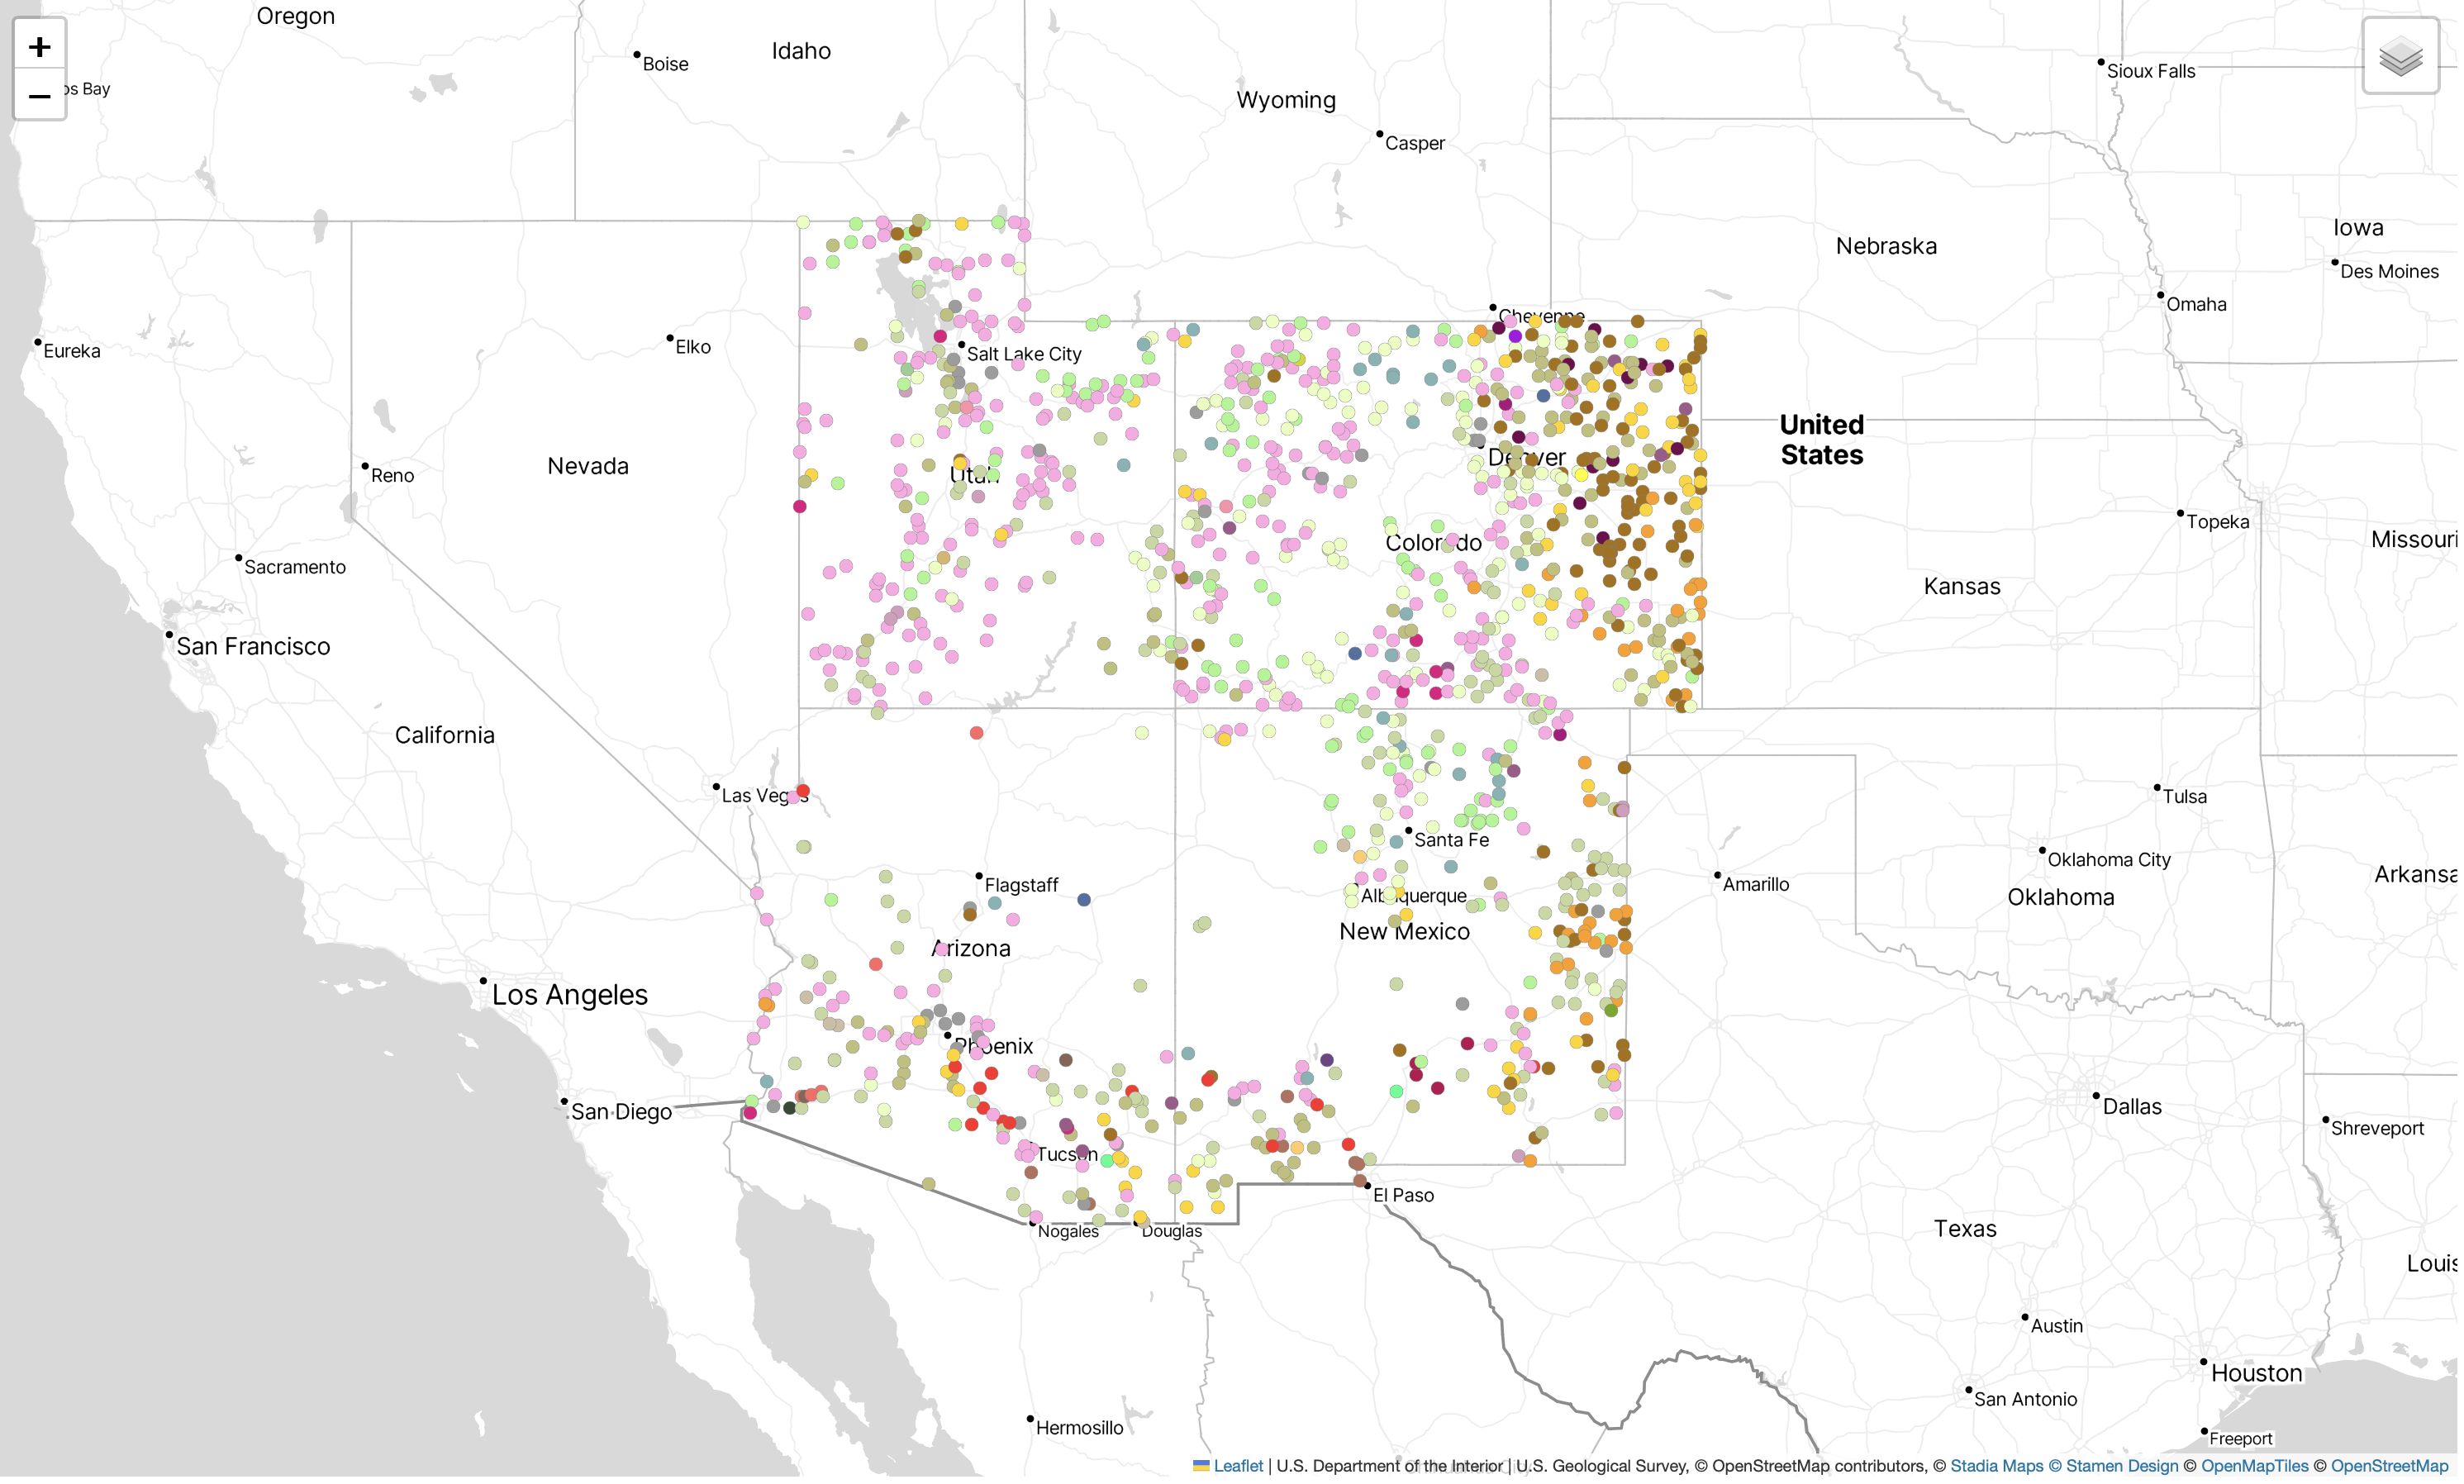 -->

## load ecocrop data

Imputed, includes USDA Hardiness Zones

In [11]:
# ecocrop_file = '../data/agricultural/EcoCrop/siads699/EcoCrop_Clean_Imputed_All.pickle'
ecocrop_file = '../data/crops/EcoCrop_Clean_Imputed_All.pickle'
ecocrop_all = pd.read_pickle(ecocrop_file)
ecocrop_all

Crop_Code            Scientific_Name         Genus         Species  \
0           289     Abelmoschus esculentus   Abelmoschus      esculentus   
1           290        Abelmoschus manihot   Abelmoschus         manihot   
2           291      Abelmoschus moschatus   Abelmoschus       moschatus   
3           295      Acacia auriculiformis        Acacia  auriculiformis   
4           297          Acacia farnesiana        Acacia      farnesiana   
...         ...                        ...           ...             ...   
2563     400000  Chamaecrista rotundifolia  Chamaecrista    rotundifolia   
2564     400001         Acacia polyacantha        Acacia     polyacantha   
2565     400002           Prosopis affinis      Prosopis         affinis   
2566     400003            Vicia dasycarpa         Vicia       dasycarpa   
2567     400004            Camelina sativa      Camelina          sativa   

     Variety        Life_Form                            Habit  \
0        NaN             herb                            erect   
1        NaN            shrub                            erect   
2        NaN  herb, sub-shrub  prostrate/procumbent/semi-erect   
3        NaN             tree                            erect   
4        NaN             tree                            erect   
...      ...              ...                              ...   
2563     NaN             herb  prostrate/procumbent/semi-erect   
2564     NaN      shrub, tree                            erect   
2565     NaN             tree                            erect   
2566     NaN             herb        climber/scrambler/scadent   
2567     NaN             herb                            erect   

                        Life_Span                                 Physiology  \
0                          annual                                single stem   
1               annual, perennial                      deciduous, multi stem   
2     annual, biennial, perennial                      deciduous, multi stem   
3                       perennial                                single stem   
4                       perennial                                single stem   
...                           ...                                        ...   
2563            annual, perennial                      deciduous, multi stem   
2564                    perennial                    single stem, multi stem   
2565                    perennial  deciduous, single stem, C3 photosynthesis   
2566                       annual                                 multi stem   
2567                       annual                                 multi stem   

                                               Category  ... Crop_Cycle_Max  \
0                                            vegetables  ...          180.0   
1     vegetables, ornamentals/turf, medicinals & aro...  ...          365.0   
2               ornamentals/turf, medicinals & aromatic  ...            0.0   
3                                           forest/wood  ...          240.0   
4     materials, ornamentals/turf, medicinals & arom...  ...          240.0   
...                                                 ...  ...            ...   
2563              forage/pasture, medicinals & aromatic  ...            0.0   
2564                         forest/wood, environmental  ...            0.0   
2565                                        forest/wood  ...            0.0   
2566                                     forage/pasture  ...            0.0   
2567                                     forage/pasture  ...            0.0   

                Use_Main     Use_Detailed      Use_Part  \
0        food & beverage         vitamins        fruits   
1        food & beverage         vitamins        leaves   
2          environmental  ornamental/turf  entire plant   
3               material       dye/tannin         stems   
4          environmental  ornamental/turf  entire plant   
...                  ...            

In [12]:
list(ecocrop_all.columns)

['Crop_Code',
 'Scientific_Name',
 'Genus',
 'Species',
 'Variety',
 'Life_Form',
 'Habit',
 'Life_Span',
 'Physiology',
 'Category',
 'Plant_Attributes',
 'Temp_Opt_Min',
 'Temp_Opt_Max',
 'Temp_Opt_Min_F',
 'Temp_Opt_Max_F',
 'Temp_Abs_Min',
 'Temp_Abs_Max',
 'Temp_Abs_Min_F',
 'Temp_Abs_Max_F',
 'Killing_Temp_Rest',
 'Killing_Temp_Growth',
 'Killing_Temp_Rest_F',
 'Killing_Temp_Growth_F',
 'Rain_Opt_Min',
 'Rain_Opt_Max',
 'Rain_Abs_Min',
 'Rain_Abs_Max',
 'Lat_Opt_Min',
 'Lat_Opt_Max',
 'Lat_Abs_Min',
 'Lat_Abs_Max',
 'Alt_Opt_Min',
 'Alt_Opt_Max',
 'Alt_Abs_Min',
 'Alt_Abs_Max',
 'pH_Opt_Min',
 'pH_Opt_Max',
 'pH_Abs_Min',
 'pH_Abs_Max',
 'Light_Opt_Min',
 'Light_Opt_Max',
 'Light_Abs_Min',
 'Light_Abs_Max',
 'Depth_Opt',
 'Depth_Abs',
 'Texture_Ops',
 'Texture_Abs',
 'Fertility_Ops',
 'Fertility_Abs',
 'Al_Toxicity_Opt',
 'Al_Toxicity_Abs',
 'Salinity_Ops',
 'Salinity_Abs',
 'Drainage_Opt',
 'Drainage_Abs',
 'Photoperiod',
 'Abiotic_Tolererance',
 'Abiotic_Susceptibility',
 'Intr

In [13]:
crop_columns = [
    'Crop_Code',
    'Scientific_Name',
    'Genus',
    'Species',
    'Variety',
    # 'Life_Form',
    # 'Habit',
    # 'Life_Span',
    # 'Physiology',
    # 'Category',
    # 'Plant_Attributes',
    # 'Temp_Opt_Min',
    # 'Temp_Opt_Max',
    # 'Temp_Opt_Min_F',
    # 'Temp_Opt_Max_F',
    # 'Temp_Abs_Min',
    # 'Temp_Abs_Max',
    # 'Temp_Abs_Min_F',
    # 'Temp_Abs_Max_F',
    # 'Killing_Temp_Rest',
    # 'Killing_Temp_Growth',
    # 'Killing_Temp_Rest_F',
    # 'Killing_Temp_Growth_F',
    # 'Rain_Opt_Min',
    # 'Rain_Opt_Max',
    # 'Rain_Abs_Min',
    # 'Rain_Abs_Max',
    # 'Lat_Opt_Min',
    # 'Lat_Opt_Max',
    # 'Lat_Abs_Min',
    # 'Lat_Abs_Max',
    # 'Alt_Opt_Min',
    # 'Alt_Opt_Max',
    # 'Alt_Abs_Min',
    # 'Alt_Abs_Max',
    # 'pH_Opt_Min',
    # 'pH_Opt_Max',
    # 'pH_Abs_Min',
    # 'pH_Abs_Max',
    # 'Light_Opt_Min',
    # 'Light_Opt_Max',
    # 'Light_Abs_Min',
    # 'Light_Abs_Max',
    # 'Depth_Opt',
    # 'Depth_Abs',
    # 'Texture_Ops',
    # 'Texture_Abs',
    # 'Fertility_Ops',
    # 'Fertility_Abs',
    # 'Al_Toxicity_Opt',
    # 'Al_Toxicity_Abs',
    # 'Salinity_Ops',
    # 'Salinity_Abs',
    # 'Drainage_Opt',
    # 'Drainage_Abs',
    # 'Photoperiod',
    # 'Abiotic_Tolererance',
    # 'Abiotic_Susceptibility',
    # 'Introduction_Risks',
    # 'Production_System',
    # 'Cropping_System',
    # 'Subsystem',
    # 'Companion_Species',
    # 'Level_of_Mechanization',
    # 'Labour_Intensity',
    # 'Crop_Cycle_Min',
    # 'Crop_Cycle_Max',
    # 'Use_Main',
    # 'Use_Detailed',
    # 'Use_Part',
    'Climate_Zone_Trewartha',
    # 'USDA_Hardiness_Zone',
    # 'USDA_Hardiness_Zone_Min',
    # 'USDA_Hardiness_Zone_Max',
    # 'Datasheet_URL',
    # 'PFAF_URL'
]

In [14]:
crops_data = ecocrop_all[crop_columns]
crops_data

Crop_Code            Scientific_Name         Genus         Species  \
0           289     Abelmoschus esculentus   Abelmoschus      esculentus   
1           290        Abelmoschus manihot   Abelmoschus         manihot   
2           291      Abelmoschus moschatus   Abelmoschus       moschatus   
3           295      Acacia auriculiformis        Acacia  auriculiformis   
4           297          Acacia farnesiana        Acacia      farnesiana   
...         ...                        ...           ...             ...   
2563     400000  Chamaecrista rotundifolia  Chamaecrista    rotundifolia   
2564     400001         Acacia polyacantha        Acacia     polyacantha   
2565     400002           Prosopis affinis      Prosopis         affinis   
2566     400003            Vicia dasycarpa         Vicia       dasycarpa   
2567     400004            Camelina sativa      Camelina          sativa   

     Variety                             Climate_Zone_Trewartha  
0        NaN  tropical wet & dry (Aw), tropical wet (Ar), st...  
1        NaN         tropical wet & dry (Aw), tropical wet (Ar)  
2        NaN                            tropical wet & dry (Aw)  
3        NaN         tropical wet & dry (Aw), tropical wet (Ar)  
4        NaN  tropical wet & dry (Aw), steppe or semiarid (B...  
...      ...                                                ...  
2563     NaN  tropical wet & dry (Aw), tropical wet (Ar), su...  
2564     NaN       desert or arid (Bw), steppe or semiarid (Bs)  
2565     NaN  tropical wet & dry (Aw), desert or arid (Bw), ...  
2566     NaN  tropical wet & dry (Aw), tropical wet (Ar), st...  
2567     NaN         tropical wet & dry (Aw), tropical wet (Ar)  

[2568 rows x 6 columns]

In [15]:
crops_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568 entries, 0 to 2567
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Crop_Code               2568 non-null   int64 
 1   Scientific_Name         2568 non-null   object
 2   Genus                   2568 non-null   object
 3   Species                 2568 non-null   object
 4   Variety                 72 non-null     object
 5   Climate_Zone_Trewartha  2568 non-null   object
dtypes: int64(1), object(5)
memory usage: 120.5+ KB


In [16]:
list(crops_data['Variety'].unique())[:10]

[nan,
 'dulce',
 'cepa',
 'botrytis',
 'capitata',
 'gemmifera',
 'italica',
 'aggregatum',
 'piperascens',
 'flavicarpa']

In [17]:
len(list(crops_data['Variety'].unique()))

72

In [18]:
crops_data['Climate_Zone_Trewartha'].unique()

array(['tropical wet & dry (Aw), tropical wet (Ar), steppe or semiarid (Bs), subtropical humid (Cf), subtropical dry summer (Cs), subtropical dry winter (Cw)',
       'tropical wet & dry (Aw), tropical wet (Ar)',
       'tropical wet & dry (Aw)',
       'tropical wet & dry (Aw), steppe or semiarid (Bs), subtropical dry summer (Cs)',
       'tropical wet & dry (Aw), steppe or semiarid (Bs)',
       'desert or arid (Bw), steppe or semiarid (Bs)',
       'tropical wet & dry (Aw), tropical wet (Ar), subtropical humid (Cf)',
       'subtropical humid (Cf)', 'tropical wet (Ar)',
       'tropical wet & dry (Aw), subtropical humid (Cf)',
       'tropical wet & dry (Aw), subtropical humid (Cf), subtropical dry summer (Cs), subtropical dry winter (Cw)',
       'tropical wet & dry (Aw), steppe or semiarid (Bs), subtropical humid (Cf)',
       'subtropical dry summer (Cs)',
       'tropical wet & dry (Aw), subtropical humid (Cf), subtropical dry summer (Cs)',
       'tropical wet & dry (Aw), subtr

## get Köppen-Geiger climate zone for each field

In [19]:
# climate_zone_file = '../data/climate_zones/koppen_geiger/1991_2020/koppen_geiger_1p0.tif'
climate_zone_file = '../data/zones/koppen_geiger/koppen_geiger_1p0_1991_2020.tif'

# climate_zone_data_folder = '../data/climate_zones/koppen_geiger/'
climate_zone_data_folder = '../data/zones/koppen_geiger/'

climate_zone_scenarios_filenames = [
    'koppen_geiger_1p0_1991_2020.tif',
    'koppen_geiger_1p0_2041_2070_ssp245.tif',
    'koppen_geiger_1p0_2041_2070_ssp585.tif'
]

climate_zone_scenarios = ['historical_1991_2020', 'ssp245_2041_2070', 'ssp585_2041_2070']

In [20]:
# Ensure field data is in the correct CRS
with rasterio.open(climate_zone_file) as src:
    field_data = field_data.to_crs(src.crs)

In [21]:
# Extract coordinates for sampling using Latitude and Longitude columns
coords = [(x, y) for x, y in zip(field_data['Longitude'], field_data['Latitude'])]

In [22]:
# # Sample raster at field locations
# with rasterio.open(climate_zone_file) as src:
#     climate_zones = list(src.sample(coords))

# Convert sampled values to a DataFrame and merge with field data
# field_data['Climate_Zone_ID'] = [val[0] for val in climate_zones]

In [23]:
# Extract coordinates for sampling using Latitude and Longitude columns
coords = [(x, y) for x, y in zip(field_data['Longitude'], field_data['Latitude'])]

# Sample each climate scenario at the field locations and store in separate columns
for scenario, filename in zip(climate_zone_scenarios, climate_zone_scenarios_filenames):
    climate_zone_file = climate_zone_data_folder + filename
    with rasterio.open(climate_zone_file) as src:
        climate_zones = list(src.sample(coords))
    
    # Convert sampled values to a DataFrame column
    field_data[f'Climate_Zone_ID_{scenario}'] = [val[0] for val in climate_zones]

In [24]:
field_data['Climate_Zone_ID_historical_1991_2020'].unique() 

array([ 7, 26,  5,  4, 27,  6], dtype=uint8)

In [25]:
field_data['Climate_Zone_ID_ssp245_2041_2070'].unique()

array([ 7,  5,  4,  6, 26, 27], dtype=uint8)

In [26]:
field_data['Climate_Zone_ID_ssp585_2041_2070'].unique()

array([ 7,  5,  4,  6, 26], dtype=uint8)

In [27]:
field_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## translate Köppen-Geiger zones to Trewartha zones

EcoCrop uses Trewartha, an updated version of Köppen-Geiger

In [28]:
# Define the Trewartha to Köppen–Geiger mapping
trewartha_to_koppen = {
    'Aw': ['Aw'],                  # Tropical wet & dry
    'Ar': ['Af', 'Am'],            # Tropical wet
    'Bs': ['BSh', 'BSk'],          # Steppe or semiarid
    'Cf': ['Cfa', 'Cfb', 'Cfc'],   # Subtropical humid
    'Cs': ['Csa', 'Csb', 'Csc'],   # Subtropical dry summer
    'Cw': ['Cwa', 'Cwb', 'Cwc'],   # Subtropical dry winter
    'Bw': ['BWh', 'BWk'],          # Desert or arid
    'Do': ['Cfb', 'Cfc'],          # Temperate oceanic
    'Dc': ['Dfa', 'Dfb', 'Dfc', 'Dfd'],  # Temperate continental
    'Df': ['Dfa', 'Dfb', 'Dfc', 'Dfd'],  # Temperate with humid winters
    'Dw': ['Dwa', 'Dwb', 'Dwc', 'Dwd'],  # Temperate with dry winters
    'E' : ['ET'],                  # Boreal
    'F' : ['EF']                   # Polar
}

In [29]:
# zone_descriptions = pd.read_csv('../data/climate_zones/koppen_geiger/legend.csv', names=['zone_id', 'zone_abbreviation', 'zone_description', 'zone_rgb'])
zone_descriptions = pd.read_csv('../data/zones/koppen_geiger/legend.csv', names=['zone_id', 'zone_abbreviation', 'zone_description', 'zone_rgb'])
zone_descriptions['zone_abbreviation'] = zone_descriptions['zone_abbreviation'].str.strip()
zone_descriptions

zone_id zone_abbreviation                        zone_description  \
0         1                Af  Tropical, rainforest                     
1         2                Am  Tropical, monsoon                        
2         3                Aw  Tropical, savannah                       
3         4               BWh  Arid, desert, hot                        
4         5               BWk  Arid, desert, cold                       
5         6               BSh  Arid, steppe, hot                        
6         7               BSk  Arid, steppe, cold                       
7         8               Csa  Temperate, dry summer, hot summer        
8         9               Csb  Temperate, dry summer, warm summer       
9        10               Csc  Temperate, dry summer, cold summer       
10       11               Cwa  Temperate, dry winter, hot summer        
11       12               Cwb  Temperate, dry winter, warm summer       
12       13               Cwc  Temperate, dry winter, cold summer       
13       14               Cfa  Temperate, no dry season, hot summer     
14       15               Cfb  Temperate, no dry season, warm summer    
15       16               Cfc  Temperate, no dry season, cold summer    
16       17               Dsa  Cold, dry summer, hot summer             
17       18               Dsb  Cold, dry summer, warm summer            
18       19               Dsc  Cold, dry summer, cold summer            
19       20               Dsd  Cold, dry summer, very cold winter       
20       21               Dwa  Cold, dry winter, hot summer             
21       22               Dwb  Cold, dry winter, warm summer            
22       23               Dwc  Cold, dry winter, cold summer            
23       24               Dwd  Cold, dry winter, very cold winter       
24       25               Dfa  Cold, no dry season, hot summer          
25       26               Dfb  Cold, no dry season, warm summer         
26       27               Dfc  Cold, no dry season, cold summer         
27       28               Dfd  Cold, no dry season, very cold winter    
28       29                ET  Polar, tundra                            
29       30                EF  Polar, frost                             

         zone_rgb  
0       [0 0 255]  
1     [0 120 255]  
2    [70 170 250]  
3       [255 0 0]  
4   [255 150 150]  
5     [245 165 0]  
6   [255 220 100]  
7     [255 255 0]  
8     [200 200 0]  
9     [150 150 0]  
10  [150 255 150]  
11  [100 200 100]  
12    [50 150 50]  
13   [200 255 80]  
14   [100 255 80]  
15     [50 200 0]  
16    [255 0 255]  
17    [200 0 200]  
18   [150 50 150]  
19  [150 100 150]  
20  [170 175 255]  
21   [90 120 220]  
22    [75 80 180]  
23     [50 0 135]  
24    [0 255 255]  
25   [55 200 255]  
26    [0 125 125]  
27      [0 70 95]  
28  [178 178 178]  
29  [102 102 102]

In [30]:
zone_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   zone_id            30 non-null     int64 
 1   zone_abbreviation  30 non-null     object
 2   zone_description   30 non-null     object
 3   zone_rgb           30 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB


In [31]:
# Create a dictionary to map zone_id to zone_description
zone_id_to_description = dict(zip(zone_descriptions['zone_id'], zone_descriptions['zone_description']))
# zone_id_to_description

In [32]:
abbreviation_to_zone_ids = dict(zip(zone_descriptions['zone_abbreviation'], zone_descriptions['zone_id']))
abbreviation_to_zone_ids

{'Af': 1,
 'Am': 2,
 'Aw': 3,
 'BWh': 4,
 'BWk': 5,
 'BSh': 6,
 'BSk': 7,
 'Csa': 8,
 'Csb': 9,
 'Csc': 10,
 'Cwa': 11,
 'Cwb': 12,
 'Cwc': 13,
 'Cfa': 14,
 'Cfb': 15,
 'Cfc': 16,
 'Dsa': 17,
 'Dsb': 18,
 'Dsc': 19,
 'Dsd': 20,
 'Dwa': 21,
 'Dwb': 22,
 'Dwc': 23,
 'Dwd': 24,
 'Dfa': 25,
 'Dfb': 26,
 'Dfc': 27,
 'Dfd': 28,
 'ET': 29,
 'EF': 30}

In [33]:
# Function to create the translation table
def create_translation_table(trewartha_to_koppen, koppen_geiger_df):
    translation_data = []
    for trewartha, koppen_list in trewartha_to_koppen.items():
        for koppen in koppen_list:
            zone_info = koppen_geiger_df[koppen_geiger_df['zone_abbreviation'].str.strip() == koppen].iloc[0]
            translation_data.append({
                'Trewartha': trewartha,
                'Koppen_Geiger': koppen,
                'zone_id': zone_info['zone_id'],
                'zone_description': zone_info['zone_description']
            })
    return pd.DataFrame(translation_data)

# Create the translation table
translation_df = create_translation_table(trewartha_to_koppen, zone_descriptions)
translation_df

Trewartha Koppen_Geiger  zone_id                        zone_description
0         Aw            Aw        3  Tropical, savannah                    
1         Ar            Af        1  Tropical, rainforest                  
2         Ar            Am        2  Tropical, monsoon                     
3         Bs           BSh        6  Arid, steppe, hot                     
4         Bs           BSk        7  Arid, steppe, cold                    
5         Cf           Cfa       14  Temperate, no dry season, hot summer  
6         Cf           Cfb       15  Temperate, no dry season, warm summer 
7         Cf           Cfc       16  Temperate, no dry season, cold summer 
8         Cs           Csa        8  Temperate, dry summer, hot summer     
9         Cs           Csb        9  Temperate, dry summer, warm summer    
10        Cs           Csc       10  Temperate, dry summer, cold summer    
11        Cw           Cwa       11  Temperate, dry winter, hot summer     
12        Cw           Cwb       12  Temperate, dry winter, warm summer    
13        Cw           Cwc       13  Temperate, dry winter, cold summer    
14        Bw           BWh        4  Arid, desert, hot                     
15        Bw           BWk        5  Arid, desert, cold                    
16        Do           Cfb       15  Temperate, no dry season, warm summer 
17        Do           Cfc       16  Temperate, no dry season, cold summer 
18        Dc           Dfa       25  Cold, no dry season, hot summer       
19        Dc           Dfb       26  Cold, no dry season, warm summer      
20        Dc           Dfc       27  Cold, no dry season, cold summer      
21        Dc           Dfd       28  Cold, no dry season, very cold winter 
22        Df           Dfa       25  Cold, no dry season, hot summer       
23        Df           Dfb       26  Cold, no dry season, warm summer      
24        Df           Dfc       27  Cold, no dry season, cold summer      
25        Df           Dfd       28  Cold, no dry season, very cold winter 
26        Dw           Dwa       21  Cold, dry winter, hot summer          
27        Dw           Dwb       22  Cold, dry winter, warm summer         
28        Dw           Dwc       23  Cold, dry winter, cold summer         
29        Dw           Dwd       24  Cold, dry winter, very cold winter    
30         E            ET       29  Polar, tundra                         
31         F            EF       30  Polar, frost

In [34]:
# Extract abbreviations and create the Climate_Zone_IDs column and the dictionary
abbreviation_to_description = {}

def extract_abbreviations(description_str):
    abbreviations = []
    parts = description_str.split(',')
    for part in parts:
        # Find the part within parentheses
        start = part.find('(')
        end = part.find(')')
        if start != -1 and end != -1:
            abbreviation = part[start+1:end].strip()
            description = part[:start].strip()
            abbreviations.append(abbreviation)
            abbreviation_to_description[abbreviation] = description
    return abbreviations

# def map_abbreviations_to_ids(abbreviation_list, abbr_to_id_map):
#     return [abbr_to_id_map[abbr] for abbr in abbreviation_list if abbr in abbr_to_id_map]


In [35]:
crops_data = crops_data.copy()

crops_data.loc[:,'Climate_Zone_Trewartha_Abbreviations'] = crops_data['Climate_Zone_Trewartha'].apply(extract_abbreviations)

crops_data['Climate_Zone_Trewartha_Abbreviations']

0                       [Aw, Ar, Bs, Cf, Cs, Cw]
1                                       [Aw, Ar]
2                                           [Aw]
3                                       [Aw, Ar]
4                                   [Aw, Bs, Cs]
                          ...                   
2563                        [Aw, Ar, Cf, Cs, Do]
2564                                    [Bw, Bs]
2565                                [Aw, Bw, Bs]
2566    [Aw, Ar, Bs, Cf, Cs, Cw, Do, Dc, Df, Dw]
2567                                    [Aw, Ar]
Name: Climate_Zone_Trewartha_Abbreviations, Length: 2568, dtype: object

In [36]:
# Function to translate Trewartha to Köppen–Geiger
def translate_trewartha_to_koppen(trewartha_list, mapping):
    koppen_list = []
    for trewartha in trewartha_list:
        koppen_list.extend(mapping.get(trewartha, []))
    return list(set(koppen_list))  # Remove duplicates

# Apply the function to create the new column
crops_data['Climate_Zone_Koppen_Geiger_Abbreviations'] = crops_data['Climate_Zone_Trewartha_Abbreviations'].apply(
    lambda x: translate_trewartha_to_koppen(x, trewartha_to_koppen)
)

crops_data['Climate_Zone_Koppen_Geiger_Abbreviations']


0       [Aw, Cwa, Csc, Cwb, BSh, Cwc, Af, Csa, BSk, Cf...
1                                            [Aw, Af, Am]
2                                                    [Aw]
3                                            [Aw, Af, Am]
4                           [Aw, Csc, BSh, Csa, BSk, Csb]
                              ...                        
2563           [Aw, Csc, Af, Csa, Cfb, Cfc, Am, Cfa, Csb]
2564                                 [BWk, BWh, BSh, BSk]
2565                             [Aw, BSh, BSk, BWk, BWh]
2566    [Aw, Dwd, Cwc, Dfb, Dwb, Dfa, BSk, Dwc, Cfa, C...
2567                                         [Aw, Af, Am]
Name: Climate_Zone_Koppen_Geiger_Abbreviations, Length: 2568, dtype: object

In [37]:
# Function to translate Köppen–Geiger abbreviations to IDs
def translate_koppen_to_ids(koppen_list, mapping):
    return [mapping[abbr] for abbr in koppen_list if abbr in mapping]

# Apply the function to create the new column
crops_data['Climate_Zone_Koppen_Geiger_IDs'] = crops_data['Climate_Zone_Koppen_Geiger_Abbreviations'].apply(
    lambda x: translate_koppen_to_ids(x, abbreviation_to_zone_ids)
)

crops_data['Climate_Zone_Koppen_Geiger_IDs']

0       [3, 11, 10, 12, 6, 13, 1, 8, 7, 15, 16, 2, 14, 9]
1                                               [3, 1, 2]
2                                                     [3]
3                                               [3, 1, 2]
4                                     [3, 10, 6, 8, 7, 9]
                              ...                        
2563                      [3, 10, 1, 8, 15, 16, 2, 14, 9]
2564                                         [5, 4, 6, 7]
2565                                      [3, 6, 7, 5, 4]
2566    [3, 24, 13, 26, 22, 25, 7, 23, 14, 12, 15, 2, ...
2567                                            [3, 1, 2]
Name: Climate_Zone_Koppen_Geiger_IDs, Length: 2568, dtype: object

In [38]:
# Convert the lists of climate zone IDs to a DataFrame where each column represents a crop
max_len = max(crops_data['Climate_Zone_Koppen_Geiger_IDs'].apply(len))
crop_zone_matrix = np.full((len(crops_data), max_len), np.nan)
for i, zones in enumerate(crops_data['Climate_Zone_Koppen_Geiger_IDs']):
    crop_zone_matrix[i, :len(zones)] = zones

# Function to calculate the results matrix
def calculate_results_matrix(field_data, crops_data, scenario_field_column):
    # Prepare the result matrix
    result_matrix = np.zeros((len(field_data), len(crops_data)), dtype=int)

    # Extract the climate zone IDs for fields and crops
    field_zones = field_data[scenario_field_column].values.reshape(-1, 1)

    # Use broadcasting to create the result matrix
    for j in range(crop_zone_matrix.shape[1]):
        matches = (field_zones == crop_zone_matrix[:, j])
        result_matrix += matches

    # Normalize the result matrix
    result_matrix = np.where(result_matrix > 0, 1, -1)

    # Handle NaN cases: if either field zone or crop zone is NaN, set the result to 0
    nan_mask_fields = np.isnan(field_zones).flatten()
    result_matrix[nan_mask_fields, :] = 0

    for i in range(len(crops_data)):
        if np.isnan(crop_zone_matrix[i]).all():
            result_matrix[:, i] = 0

    # Convert the numpy matrix to a DataFrame
    results_df = pd.DataFrame(result_matrix, index=field_data['CSBID'], columns=crops_data['Scientific_Name'])
    return results_df

In [39]:
# Initialize dictionaries to store results
results_dfs = {}

# Calculate results for each scenario
for scenario in climate_zone_scenarios:
    scenario_field_column = f'Climate_Zone_ID_{scenario}'
    results_dfs[scenario] = calculate_results_matrix(field_data, crops_data, scenario_field_column)

In [40]:
# # climate_zone_scenarios = ['historical_1991_2020', 'ssp245_2041_2070', 'ssp585_2041_2070']
# results_dfs['historical_1991_2020']

In [41]:
# results_dfs['ssp245_2041_2070']

In [42]:
# results_dfs['ssp585_2041_2070']

## save climate zone scores as a field x crop x scenario matrix

In [43]:
# Initialize an empty 3D numpy array
results_matrix = np.zeros((len(field_data), len(crops_data), len(climate_zone_scenarios)), dtype=int)

# Fill the 3D numpy array with the data from each DataFrame in the results_dfs dictionary
for scenario_index, scenario in enumerate(climate_zone_scenarios):
    df = results_dfs[scenario]
    results_matrix[:, :, scenario_index] = df.values

In [44]:
results_matrix.shape

(1200, 2568, 3)

In [45]:
# Convert the results matrix to an xarray DataArray
results_da = xr.DataArray(
    results_matrix,
    dims=['fields', 'crops', 'scenarios'],
    coords={
        'fields': field_data['CSBID'],
        'crops': crops_data['Scientific_Name'],
        'scenarios': climate_zone_scenarios
    },
    name='crop_suitability_climate_zone'
)

In [46]:
# results_da

In [47]:
# Save the DataArray to a NetCDF file
results_da.to_netcdf('../data/scores/score_matrix_climate_zone.nc')

## save fields with climate zones for each scenario

In [48]:
csb_sample_with_climate_zones = field_data.copy()

In [49]:
# set crs for sample file
csb_sample_with_climate_zones.to_crs(crs='EPSG:4269', inplace=True)

In [50]:
# csb_sample_with_climate_zones.to_parquet('../data/public/csb_sample_with_climate_zones.parquet')
csb_sample_with_climate_zones.to_parquet('../data/fields/csb_sample_with_climate_zones.parquet')

## save crops data with Köppen-Geiger climate zones

In [51]:
crops_data.columns

Index(['Crop_Code', 'Scientific_Name', 'Genus', 'Species', 'Variety',
       'Climate_Zone_Trewartha', 'Climate_Zone_Trewartha_Abbreviations',
       'Climate_Zone_Koppen_Geiger_Abbreviations',
       'Climate_Zone_Koppen_Geiger_IDs'],
      dtype='object')

In [52]:
ecocrop_with_koppen_geiger_climate_zones = ecocrop_all.copy()


ecocrop_with_koppen_geiger_climate_zones[[
    'Climate_Zone_Trewartha_Abbreviations',
    'Climate_Zone_Koppen_Geiger_Abbreviations',
    'Climate_Zone_Koppen_Geiger_IDs'
]] = crops_data[[
    'Climate_Zone_Trewartha_Abbreviations',
    'Climate_Zone_Koppen_Geiger_Abbreviations',
    'Climate_Zone_Koppen_Geiger_IDs'
]]

In [53]:
ecocrop_with_koppen_geiger_climate_zones.to_csv('../data/crops/EcoCrop_with_koppen_geiger_climate_zones.csv')

## evaluate results

In [54]:
# Function to get crops with a score of 1 for each field
def get_crops_with_score_1(results_df):
    crops_with_score_1 = {}
    for field_id in results_df.index:
        crops = results_df.columns[results_df.loc[field_id] == 1].tolist()
        crops_with_score_1[field_id] = crops
        # crops_with_score_1[field_id] = len(crops)
    return crops_with_score_1

In [55]:
# crops_with_score_1 = get_crops_with_score_1(results_df)
# # crops_with_score_1

In [56]:
# sorted([(n_crops, field) for field, n_crops in crops_with_score_1.items()])[:10]

In [57]:
# sorted([(n_crops, field) for field, n_crops in crops_with_score_1.items()])[-10:]

In [58]:
# Initialize the DataFrame to store the results
crops_with_score_1_df = pd.DataFrame()

# Process each scenario and add the results to the DataFrame
for scenario in climate_zone_scenarios:
    results_df = results_dfs[scenario]
    crops_with_score_1 = get_crops_with_score_1(results_df)
    
    scenario_column = f'Suitable_Crops_{scenario}'
    number_column = f'Number_of_Suitable_Crops_{scenario}'
    
    # Convert the results to a DataFrame for easier visualization
    temp_df = pd.DataFrame(list(crops_with_score_1.items()), columns=['CSBID', scenario_column])
    temp_df[number_column] = temp_df[scenario_column].apply(len)
    
    if crops_with_score_1_df.empty:
        crops_with_score_1_df = temp_df
    else:
        crops_with_score_1_df = crops_with_score_1_df.merge(temp_df, on='CSBID', how='outer')

In [59]:
crops_with_score_1_df

CSBID                Suitable_Crops_historical_1991_2020  \
0     041623001737284  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1     041623001737287  [Acacia mellifera, Amaranthus sp., Avena sativ...   
2     041623001737406  [Acacia mellifera, Amaranthus sp., Avena sativ...   
3     041623002612886  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
4     041623002612947  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
...               ...                                                ...   
1195  491623016053447  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1196  491623016053449  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1197  491623016053635  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1198  491623016053699  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1199  491623016053721  [Abelmoschus esculentus, Acacia farnesiana, Ac...   

      Number_of_Suitable_Crops_historical_1991_2020  \
0                                               327   
1                                               327   
2                                               327   
3                                               988   
4                                               988   
...                                             ...   
1195                                            327   
1196                                            327   
1197                                            988   
1198                                            988   
1199                                            988   

                        Suitable_Crops_ssp245_2041_2070  \
0     [Acacia mellifera, Amaranthus sp., Avena sativ...   
1     [Acacia mellifera, Amaranthus sp., Avena sativ...   
2     [Acacia mellifera, Amaranthus sp., Avena sativ...   
3     [Abelmoschus esculentus, Acacia farnesiana, Ac...   
4     [Abelmoschus esculentus, Acacia farnesiana, Ac...   
...                                                 ...   
1195  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1196  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1197  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1198  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1199  [Abelmoschus esculentus, Acacia farnesiana, Ac...   

      Number_of_Suitable_Crops_ssp245_2041_2070  \
0                                           327   
1                                           327   
2                                           327   
3                                           988   
4                                           988   
...                                         ...   
1195                                        327   
1196                                        327   
1197                                        988   
1198                                        988   
1199                                        988   

                        Suitable_Crops_ssp585_2041_2070  \
0     [Acacia mellifera, Amaranthus sp., Avena sativ...   
1     [Acacia mellifera, Amaranthus sp., Avena sativ...   
2     [Acacia mellifera, Amaranthus sp., Avena sativ...   
3     [Abelmoschus esculentus, Acacia farnesiana, Ac...   
4     [Abelmoschus esculentus, Acacia farnesiana, Ac...   
...                                                 ...   
1195  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1196  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1197  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1198  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1199  [Acacia mellifera, Amaranthus sp., Avena sativ...   

      Number_of_Suitable_Crops_ssp585_2041_2070  
0                                           327  
1                                           327  
2                                           327  
3                                           988  
4                                           988  
...                                         ...  
1195                                        327  
1196       

In [60]:
crops_with_score_1_df.columns

Index(['CSBID', 'Suitable_Crops_historical_1991_2020',
       'Number_of_Suitable_Crops_historical_1991_2020',
       'Suitable_Crops_ssp245_2041_2070',
       'Number_of_Suitable_Crops_ssp245_2041_2070',
       'Suitable_Crops_ssp585_2041_2070',
       'Number_of_Suitable_Crops_ssp585_2041_2070'],
      dtype='object')

In [61]:
crops_with_score_1_df[['Number_of_Suitable_Crops_historical_1991_2020', 'Number_of_Suitable_Crops_ssp245_2041_2070', 'Number_of_Suitable_Crops_ssp585_2041_2070']]

Number_of_Suitable_Crops_historical_1991_2020  \
0                                               327   
1                                               327   
2                                               327   
3                                               988   
4                                               988   
...                                             ...   
1195                                            327   
1196                                            327   
1197                                            988   
1198                                            988   
1199                                            988   

      Number_of_Suitable_Crops_ssp245_2041_2070  \
0                                           327   
1                                           327   
2                                           327   
3                                           988   
4                                           988   
...                                         ...   
1195                                        327   
1196                                        327   
1197                                        988   
1198                                        988   
1199                                        988   

      Number_of_Suitable_Crops_ssp585_2041_2070  
0                                           327  
1                                           327  
2                                           327  
3                                           988  
4                                           988  
...                                         ...  
1195                                        327  
1196                                        327  
1197                                        327  
1198                                        327  
1199                                        327  

[1200 rows x 3 columns]

In [62]:
crops_with_score_1_df[crops_with_score_1_df['Number_of_Suitable_Crops_historical_1991_2020'] != crops_with_score_1_df['Number_of_Suitable_Crops_ssp245_2041_2070']]

CSBID                Suitable_Crops_historical_1991_2020  \
26    041623004988422  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
27    041623004988423  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
85    041623011321952  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
86    041623011322371  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
87    041623011322399  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
...               ...                                                ...   
1064  491623012659359  [Allium ampeloprasum, Allium cepa, Allium fist...   
1065  491623012662053  [Allium ampeloprasum, Allium cepa, Allium fist...   
1066  491623012663282  [Allium ampeloprasum, Allium cepa, Allium fist...   
1113  491623014706074  [Allium ampeloprasum, Allium cepa, Allium fist...   
1114  491623014706205  [Allium ampeloprasum, Allium cepa, Allium fist...   

      Number_of_Suitable_Crops_historical_1991_2020  \
26                                              988   
27                                              988   
85                                              988   
86                                              988   
87                                              988   
...                                             ...   
1064                                            624   
1065                                            624   
1066                                            624   
1113                                            624   
1114                                            624   

                        Suitable_Crops_ssp245_2041_2070  \
26    [Acacia mellifera, Amaranthus sp., Avena sativ...   
27    [Acacia mellifera, Amaranthus sp., Avena sativ...   
85    [Acacia mellifera, Amaranthus sp., Avena sativ...   
86    [Acacia mellifera, Amaranthus sp., Avena sativ...   
87    [Acacia mellifera, Amaranthus sp., Avena sativ...   
...                                                 ...   
1064  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1065  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1066  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1113  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1114  [Abelmoschus esculentus, Acacia farnesiana, Ac...   

      Number_of_Suitable_Crops_ssp245_2041_2070  \
26                                          327   
27                                          327   
85                                          327   
86                                          327   
87                                          327   
...                                         ...   
1064                                        988   
1065                                        988   
1066                                        988   
1113                                        988   
1114                                        988   

                        Suitable_Crops_ssp585_2041_2070  \
26    [Acacia mellifera, Amaranthus sp., Avena sativ...   
27    [Acacia mellifera, Amaranthus sp., Avena sativ...   
85    [Acacia mellifera, Amaranthus sp., Avena sativ...   
86    [Acacia mellifera, Amaranthus sp., Avena sativ...   
87    [Acacia mellifera, Amaranthus sp., Avena sativ...   
...                                                 ...   
1064  [Allium ampeloprasum, Allium cepa, Allium fist...   
1065  [Allium ampeloprasum, Allium cepa, Allium fist...   
1066  [Allium ampeloprasum, Allium cepa, Allium fist...   
1113  [Allium ampeloprasum, Allium cepa, Allium fist...   
1114  [Allium ampeloprasum, Allium cepa, Allium fist...   

      Number_of_Suitable_Crops_ssp585_2041_2070  
26                                          327  
27                                          327  
85                                          327  
86                                          327  
87                                          327  
...                                         ...  
1064                                        624  
1065       

In [63]:
crops_with_score_1_df[crops_with_score_1_df['Number_of_Suitable_Crops_historical_1991_2020'] != crops_with_score_1_df['Number_of_Suitable_Crops_ssp585_2041_2070']]

CSBID                Suitable_Crops_historical_1991_2020  \
26    041623004988422  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
27    041623004988423  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
85    041623011321952  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
86    041623011322371  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
87    041623011322399  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
...               ...                                                ...   
1175  491623015921650  [Allium ampeloprasum, Allium cepa, Allium fist...   
1180  491623015922172  [Allium ampeloprasum, Allium cepa, Allium fist...   
1197  491623016053635  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1198  491623016053699  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1199  491623016053721  [Abelmoschus esculentus, Acacia farnesiana, Ac...   

      Number_of_Suitable_Crops_historical_1991_2020  \
26                                              988   
27                                              988   
85                                              988   
86                                              988   
87                                              988   
...                                             ...   
1175                                            624   
1180                                            624   
1197                                            988   
1198                                            988   
1199                                            988   

                        Suitable_Crops_ssp245_2041_2070  \
26    [Acacia mellifera, Amaranthus sp., Avena sativ...   
27    [Acacia mellifera, Amaranthus sp., Avena sativ...   
85    [Acacia mellifera, Amaranthus sp., Avena sativ...   
86    [Acacia mellifera, Amaranthus sp., Avena sativ...   
87    [Acacia mellifera, Amaranthus sp., Avena sativ...   
...                                                 ...   
1175  [Allium ampeloprasum, Allium cepa, Allium fist...   
1180  [Allium ampeloprasum, Allium cepa, Allium fist...   
1197  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1198  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1199  [Abelmoschus esculentus, Acacia farnesiana, Ac...   

      Number_of_Suitable_Crops_ssp245_2041_2070  \
26                                          327   
27                                          327   
85                                          327   
86                                          327   
87                                          327   
...                                         ...   
1175                                        624   
1180                                        624   
1197                                        988   
1198                                        988   
1199                                        988   

                        Suitable_Crops_ssp585_2041_2070  \
26    [Acacia mellifera, Amaranthus sp., Avena sativ...   
27    [Acacia mellifera, Amaranthus sp., Avena sativ...   
85    [Acacia mellifera, Amaranthus sp., Avena sativ...   
86    [Acacia mellifera, Amaranthus sp., Avena sativ...   
87    [Acacia mellifera, Amaranthus sp., Avena sativ...   
...                                                 ...   
1175  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1180  [Abelmoschus esculentus, Acacia farnesiana, Ac...   
1197  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1198  [Acacia mellifera, Amaranthus sp., Avena sativ...   
1199  [Acacia mellifera, Amaranthus sp., Avena sativ...   

      Number_of_Suitable_Crops_ssp585_2041_2070  
26                                          327  
27                                          327  
85                                          327  
86                                          327  
87                                          327  
...                                         ...  
1175                                        988  
1180       

In [64]:
crops_with_score_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   CSBID                                          1200 non-null   object
 1   Suitable_Crops_historical_1991_2020            1200 non-null   object
 2   Number_of_Suitable_Crops_historical_1991_2020  1200 non-null   int64 
 3   Suitable_Crops_ssp245_2041_2070                1200 non-null   object
 4   Number_of_Suitable_Crops_ssp245_2041_2070      1200 non-null   int64 
 5   Suitable_Crops_ssp585_2041_2070                1200 non-null   object
 6   Number_of_Suitable_Crops_ssp585_2041_2070      1200 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 65.8+ KB


In [65]:
# Create a DataFrame with the columns of interest
data = crops_with_score_1_df[['Number_of_Suitable_Crops_historical_1991_2020', 
                              'Number_of_Suitable_Crops_ssp245_2041_2070', 
                              'Number_of_Suitable_Crops_ssp585_2041_2070']].dropna()

# Set bin size and other properties
bin_size = 50  # Adjust bin size as needed
color = 'cornflowerblue'
opacity = 0.6
chart_width = 600
chart_height = 200

# Function to generate Altair chart
def generate_chart(data, column, title, bin_size=30, color='cornflowerblue', opacity=0.6):
    return alt.Chart(data).mark_bar(color=color, opacity=opacity).encode(
        x=alt.X(f'{column}:Q', bin=alt.Bin(step=bin_size), title=f'Binned Number of Suitable Crops for {title}', axis=alt.Axis(offset=10)),
        y=alt.Y('count()', title='Number of Fields', axis=alt.Axis(offset=10)),
    ).properties(
        title=title,
        width=chart_width,
        height=chart_height
    )

# Generate charts for each scenario
chart_h = generate_chart(data, 'Number_of_Suitable_Crops_historical_1991_2020', 'Historical Scenario (1991-2020)', bin_size, color, opacity)
chart_45 = generate_chart(data, 'Number_of_Suitable_Crops_ssp245_2041_2070', 'RCP 4.5 Scenario (2041-2070)', bin_size, color, opacity)
chart_85 = generate_chart(data, 'Number_of_Suitable_Crops_ssp585_2041_2070', 'RCP 8.5 Scenario (2041-2070)', bin_size, color, opacity)

# Combine the charts with shared axis domains
combined_chart = alt.vconcat(
    chart_h, 
    chart_45, 
    chart_85
).resolve_scale(
    x='shared',
    y='shared'
)

In [66]:
# Display the combined chart
combined_chart

alt.VConcatChart(...)